# Heuristics for Machine Learning Pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* June2022: Adding multiple plots  

## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 




# Jupyter Notebook

## 1. Setting imports and datasets paths

In [110]:
import os
import fnmatch
import sys
import argparse
import yaml
from pathlib import Path
import json    

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

import numpy as np
import pandas as pd
import seaborn as sns

from typing import Dict, List, Tuple

from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes, split_train_validate_sets

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH

#### Setting TRAINING_CURVES_PATH and RESULTS_PATH
# RESULTS_PATH='scripts/learning-pipeline/results/1st-tests-23-june-2022'
RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-01-02-03-04'
#RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-04-05-06-07'
#RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-09-10-11-12'

TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)


## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'Pandas Version: {pd.__version__}')
print(f'seaborn Version: {sns.__version__}')
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
Pandas Version: 1.4.2
seaborn Version: 0.11.1
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-01-02-03-04


## 2. Reading dictionaries and filtering files

In [111]:
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )
os.chdir(TRAINING_CURVES_PATH)
pattern = 'TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC*.json'
json_files=fnmatch.filter(  sorted(os.listdir(TRAINING_CURVES_PATH))  , pattern)
# print(files,len(files))

print(f'-------------------')
print(f'-----Stats')
for i in range(0,len(json_files)):
    print(i, json_files[i])
    
    
pattern_params = 'TEMP_DICT_TRAINING_CURVES_FOR____TRAINING_PARAMETERS*.json'
json_files_params=fnmatch.filter(  sorted(os.listdir(TRAINING_CURVES_PATH))  , pattern_params)    
    
print(f'-------------------')
print(f'----Parameters')
for i in range(0,len(json_files_params)):
    print(i, json_files_params[i])    



TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-01-02-03-04
-------------------
-----Stats
0 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_ 50_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000000500.json
1 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_ 50_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000005000.json
2 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_ 50_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000050000.json
3 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_ 50_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000500000.json
-------------

## 2. Plotting dataframes

    epochs       LR N_BatchClips FRXClips datatype    Acc [%]
0        0  lr5e-08         bc20       10    train  40.500000
1        1  lr5e-08         bc20       10    train  51.000000
2        2  lr5e-08         bc20       10    train  46.500000
3        3  lr5e-08         bc20       10    train  53.000000
4        4  lr5e-08         bc20       10    train  55.000000
..     ...      ...          ...      ...      ...        ...
95      45  lr5e-05         bc20       10     test  57.142857
96      46  lr5e-05         bc20       10     test  57.142857
97      47  lr5e-05         bc20       10     test  57.142857
98      48  lr5e-05         bc20       10     test  57.142857
99      49  lr5e-05         bc20       10     test  50.000000

[400 rows x 6 columns]


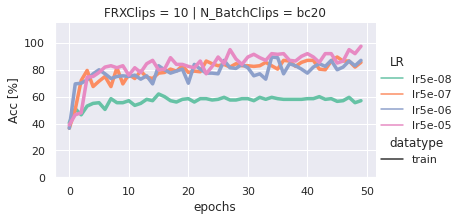

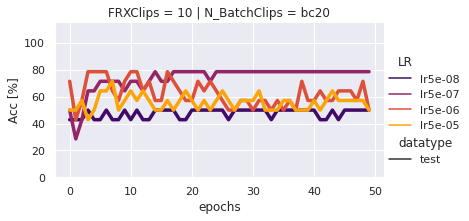

    epochs       LR N_BatchClips FRXClips datatype      Loss
0        0  lr5e-08         bc20       10    train  0.697975
1        1  lr5e-08         bc20       10    train  0.696786
2        2  lr5e-08         bc20       10    train  0.695679
3        3  lr5e-08         bc20       10    train  0.693166
4        4  lr5e-08         bc20       10    train  0.694055
..     ...      ...          ...      ...      ...       ...
95      45  lr5e-05         bc20       10     test  0.740628
96      46  lr5e-05         bc20       10     test  0.715435
97      47  lr5e-05         bc20       10     test  0.734701
98      48  lr5e-05         bc20       10     test  0.780236
99      49  lr5e-05         bc20       10     test  0.880602

[400 rows x 6 columns]


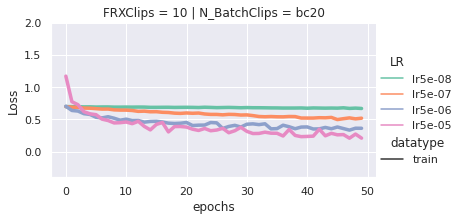

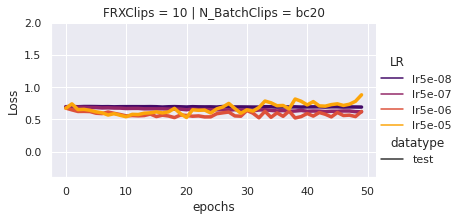

In [112]:
def json2DataFrame(PATH, FILENAME, TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips, LR,STR_VARIABLE_NAME):
    FULL_PATH_FILENAME = os.path.join(PATH, FILENAME)
    pd_read_json=pd.read_json(
                    FULL_PATH_FILENAME,
                    orient='columns',
                    typ='series')

    Filtered_JSON_stats=pd_read_json[TYPE_str]
    DFDICT = pd.DataFrame.from_dict(Filtered_JSON_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    DFDICT.insert(1, 'LR', 'lr'+str(LR), True)
    DFDICT.insert(2, 'N_BatchClips', 'bc'+str(BatchClips), True)
    DFDICT.insert(3, 'FRXClips', str(FRAMES_PER_SEGMENT_IN_A_CLIP), True)
    DFDICT.rename(columns={"variable":"datatype"} ,inplace=True)
    DFDICT.rename(columns={"value":STR_VARIABLE_NAME} ,inplace=True)
    return DFDICT 



TYPE_str = 'ACC'    
FRAMES_PER_SEGMENT_IN_A_CLIP = 10
BatchClips=20
STR_VARIABLE_NAME = 'Acc [%]'
acc0_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[0]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000000500, STR_VARIABLE_NAME)
acc1_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[1]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000005000, STR_VARIABLE_NAME)
acc2_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[2]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000050000, STR_VARIABLE_NAME)
acc3_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[3]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000500000, STR_VARIABLE_NAME)
acc_dfall = [acc0_all_, acc1_all_,acc2_all_,acc3_all_]
acc_all = pd.concat(acc_dfall)
print(acc_all)


sns.set(style="darkgrid")#sns.set(style="ticks")
g0=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'train'"))#data=acc_all)
g0.set(ylim=(0, 115))

sns.set(style="darkgrid")
g1=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="inferno",#palette=palette,
            data=acc_all.query("datatype == 'test'"))#data=acc_all)
g1.set(ylim=(0, 115))

plt.show()


TYPE_str = 'LOS'    
FRAMES_PER_SEGMENT_IN_A_CLIP = 10
BatchClips=20
STR_VARIABLE_NAME = 'Loss'
loss0_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[0]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000000500, STR_VARIABLE_NAME)
loss1_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[1]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000005000, STR_VARIABLE_NAME)
loss2_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[2]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000050000, STR_VARIABLE_NAME)
loss3_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[3]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,0.0000500000, STR_VARIABLE_NAME)
loss_dfall = [loss0_all_, loss1_all_,loss2_all_,loss3_all_]
loss_all = pd.concat(loss_dfall)
print(loss_all)


sns.set(style="darkgrid")#sns.set(style="ticks")
g2=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'train'"))#data=acc_all)
g2.set(ylim=(-0.4, 2))

sns.set(style="darkgrid")
g3=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="inferno",#palette=palette,
            data=loss_all.query("datatype == 'test'"))#data=acc_all)
g3.set(ylim=(-0.4, 2))

plt.show()
    

## 3. Plotting Paramters of Performance

   Learning Rates  Training time [secs]
0    5.000000e-08             22.231896
1    5.000000e-07             22.224005
2    5.000000e-06             21.970815
3    5.000000e-05             21.602273


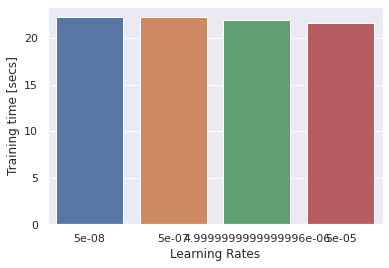

In [113]:
def jsonPARAMS2DataFrame(PATH, FILENAME):
    FULL_PATH_FILENAME = os.path.join(PATH, FILENAME)
    pd_read_json=pd.read_json(
                    FULL_PATH_FILENAME,
                    orient='columns',
                    typ='series')
    return pd_read_json

tr_s=[]
lr_d=[]
for i in range(0, len(json_files_params)):
    params=jsonPARAMS2DataFrame(TRAINING_CURVES_PATH,str(json_files_params[i]))
    tr_s.append(params[0])
    lr_d.append(params[2])
    


tr_df = pd.DataFrame(tr_s).reset_index(drop=True)
tr_df.rename(columns={0:"Training time [secs]"}, inplace=True)
lr_df = pd.DataFrame(lr_df).reset_index(drop=True)
lr_df.rename(columns={0:"Learning Rates"}, inplace=True)

df = pd.concat([lr_df, tr_df ], axis=1)
print(df)

ax = sns.barplot(x="Learning Rates", y="Training time [secs]", data=df)
# # #https://seaborn.pydata.org/generated/seaborn.barplot.html


## 2. Prototypes

/home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests-23-june-2022/TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_02_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000050000.json
/home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests-23-june-2022/TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_02_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000500000.json
/home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests-23-june-2022/TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000050000.json
/home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests-23-june-2022/TEMP_DICT_TRAININ

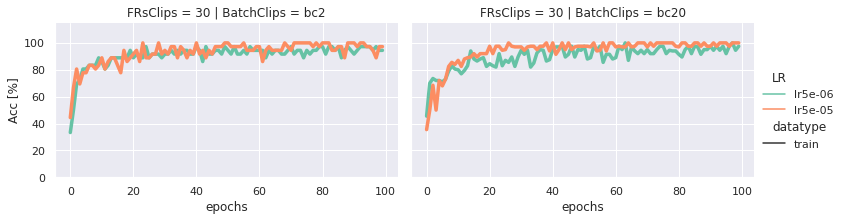

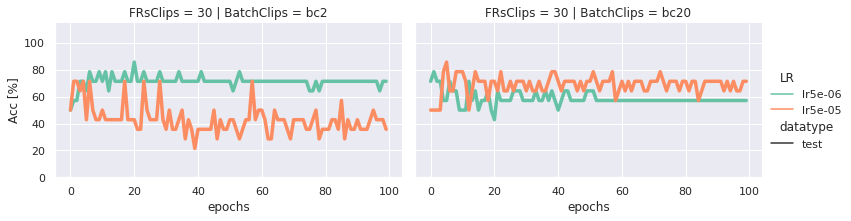

In [53]:
##RESULTS_PATH='scripts/learning-pipeline/results/1st-tests-23-june-2022'
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )
os.chdir(TRAINING_CURVES_PATH)
list_of_files = os.listdir(TRAINING_CURVES_PATH)

json_files = [i for i in list_of_files if i.endswith('.json')]
json_files = sorted(json_files)
#print(json_files)

for i in range(0,len(json_files)):
    print(i, json_files[i])

#TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_ 50_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000000500


def json2Frame(PATH, FILENAME, BatchClips, LR, STR_VARIABLE_NAME):
    FULL_PATH_FILENAME = os.path.join(PATH, FILENAME)
    print(FULL_PATH_FILENAME)
    df=pd.read_json(FULL_PATH_FILENAME,orient='columns')
    DFDICT = pd.DataFrame.from_dict(df).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    DFDICT.insert(1, 'LR', 'lr'+str(LR), True)
    DFDICT.insert(2, 'BatchClips', 'bc'+str(BatchClips), True)
    DFDICT.insert(3, 'FRsClips', str(30), True)
    DFDICT.rename(columns={"variable":"datatype"} ,inplace=True)
    DFDICT.rename(columns={"value":STR_VARIABLE_NAME} ,inplace=True)
    return DFDICT 

BatchClips_1=2
BatchClips_2=20
LEARNING_RATE_1=0.0000050000
LEARNING_RATE_2=0.0000500000
STR_VARIABLE_NAME = 'Acc [%]'



##RESULTS_PATH='scripts/learning-pipeline/results/1st-tests-23-june-2022'
acc_df0=json2Frame(TRAINING_CURVES_PATH,str(json_files[0]),BatchClips_1,LEARNING_RATE_1, STR_VARIABLE_NAME)
acc_df1=json2Frame(TRAINING_CURVES_PATH,str(json_files[1]),BatchClips_1,LEARNING_RATE_2, STR_VARIABLE_NAME)
acc_df3=json2Frame(TRAINING_CURVES_PATH,str(json_files[2]),BatchClips_2,LEARNING_RATE_1, STR_VARIABLE_NAME)
acc_df4=json2Frame(TRAINING_CURVES_PATH,str(json_files[3]),BatchClips_2,LEARNING_RATE_2, STR_VARIABLE_NAME)
acc_dfall = [acc_df0, acc_df1,acc_df3,acc_df4]
acc_all = pd.concat(acc_dfall)
print(acc_all)

sns.set(style="darkgrid")#sns.set(style="ticks")
g0=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'train'"))#data=acc_all)
g0.set(ylim=(0, 115))

sns.set(style="darkgrid")
g1=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'test'"))#data=acc_all)
g1.set(ylim=(0, 115))

plt.show()


STR_VARIABLE_NAME = 'Loss'

loss_df0=json2Frame(TRAINING_CURVES_PATH,str(json_files[4]),BatchClips_1,LEARNING_RATE_1,STR_VARIABLE_NAME)
loss_df1=json2Frame(TRAINING_CURVES_PATH,str(json_files[5]),BatchClips_1,LEARNING_RATE_2,STR_VARIABLE_NAME)
loss_df3=json2Frame(TRAINING_CURVES_PATH,str(json_files[6]),BatchClips_2,LEARNING_RATE_1,STR_VARIABLE_NAME)
loss_df4=json2Frame(TRAINING_CURVES_PATH,str(json_files[7]),BatchClips_2,LEARNING_RATE_2,STR_VARIABLE_NAME)
loss_dfall = [loss_df0, loss_df1, loss_df3, loss_df4]
loss_all = pd.concat(loss_dfall)
print(loss_all)

sns.set(style="darkgrid")#sns.set(style="ticks")
g2=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'train'"))#data=acc_all)
g2.set(ylim=(-0.4, 2))


sns.set(style="darkgrid")
g3=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'test'"))#data=acc_all)
g3.set(ylim=(-0.4, 2))

plt.show()
